In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f'pytorch version: {torch.__version__}')
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

pytorch version: 1.7.0+cu101
device: cuda:0


# Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train=datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
mnist_test=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)
print('Done')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Done


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Iterator

In [3]:
BATCH_SIZE=256
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

# Define Model

In [4]:
class ConvolutionNeuralNetworkClass(nn.Module):
    def __init__(self,name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,USE_BATCHNORM=False): # (Good): Convolution layer cdims, MLP hdims을 사용자에게 인풋받을 수 있는게 네트워크 튜닝에 편하다.
        super(ConvolutionNeuralNetworkClass,self).__init__()
        self.name=name
        self.xdim=xdim
        self.ksize=ksize
        self.cdims=cdims
        self.hdims=hdims
        self.ydim=ydim
        self.USE_BATCHNORM=USE_BATCHNORM

        #Convolutional Layers
        self.layers=[]
        prev_cdim=self.xdim[0]
        for cdim in self.cdims:
            self.layers.append(
                nn.Conv2d(
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1,1),
                    padding=self.ksize//2
                )
            )
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) #batch-norm
            self.layers.append(nn.ReLU(True)) # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))) #max-pooling
            self.layers.append(nn.Dropout2d(p=0.5)) #dropout
            prev_cdim=cdim
        
        # Dense layers
        self.layers.append(nn.Flatten())
        prev_hdim=prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.ReLU(True))
            prev_hdim=hdim
        
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers
        self.net=nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name=f'{type(layer).__name__.lower()}_{l_idx}'
            self.net.add_module(layer_name,layer) # Sequential에서 add_module : layer이름 같이 정할 수 있다는 이점 # (Good) for debugging
        self.init_param()

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init_conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init_BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self,x):
        return self.net(x)

C=ConvolutionNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10
).to(device)
loss=nn.CrossEntropyLoss()
optm=optim.Adam(C.parameters(),lr=1e-3)
print('Done')

Done


# Check parameters

In [5]:
# from torchsummary import summary
# C=ConvolutionNeuralNetworkClass(
#     name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
#     hdims=[32],ydim=10
# ).to(device)
# summary(C,input_size=(1,28,28))

In [6]:
np.set_printoptions(precision=3)
n_param=0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy=param.detach().cpu().numpy()
        n_param+=len(param_numpy.reshape(-1))
        print(f'{p_idx} name:{param_name} shape:{param_numpy.shape}') 
        print(f'val: {param_numpy.reshape(-1)[:5]}')
print(f'total number of parameters:{n_param}')

0 name:net.conv2d_0.weight shape:(32, 1, 3, 3)
val: [ 0.691 -0.058 -0.343 -0.012  0.495]
1 name:net.conv2d_0.bias shape:(32,)
val: [0. 0. 0. 0. 0.]
2 name:net.conv2d_4.weight shape:(64, 32, 3, 3)
val: [-0.022  0.118  0.096 -0.01  -0.037]
3 name:net.conv2d_4.bias shape:(64,)
val: [0. 0. 0. 0. 0.]
4 name:net.linear_9.weight shape:(32, 3136)
val: [ 0.029 -0.005  0.032 -0.012  0.008]
5 name:net.linear_9.bias shape:(32,)
val: [0. 0. 0. 0. 0.]
6 name:net.linear_11.weight shape:(10, 32)
val: [ 0.102  0.189 -0.013  0.129  0.183]
7 name:net.linear_11.bias shape:(10,)
val: [0. 0. 0. 0. 0.]
total number of parameters:119530


# Simple Forward Path of the CNN Model

In [7]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy=np.random.rand(2,1,28,28)
x_torch=torch.from_numpy(x_numpy).float().to(device)
y_torch=C.forward(x_torch)
y_numpy=y_torch.detach().cpu().numpy()
print(f'xtorch : {x_torch}')
print(f'ytorch : {y_torch}')
print(f'xnumpy : {(x_numpy.shape,x_numpy)}')
print(f'ynumpy : {(y_numpy.shape,y_numpy)}')


xtorch : tensor([[[[0.840, 0.123, 0.351,  ..., 0.981, 0.375, 0.407],
          [0.663, 0.504, 0.128,  ..., 0.315, 0.408, 0.974],
          [0.798, 0.254, 0.968,  ..., 0.278, 0.758, 0.782],
          ...,
          [0.412, 0.177, 0.310,  ..., 0.434, 0.951, 0.900],
          [0.203, 0.671, 0.147,  ..., 0.369, 0.044, 0.254],
          [0.124, 0.410, 0.246,  ..., 0.311, 0.601, 0.518]]],


        [[[0.015, 0.717, 0.722,  ..., 0.462, 0.054, 0.731],
          [0.547, 0.467, 0.193,  ..., 0.369, 0.844, 0.309],
          [0.666, 0.124, 0.848,  ..., 0.846, 0.901, 0.278],
          ...,
          [0.641, 0.885, 0.306,  ..., 0.425, 0.508, 0.522],
          [0.779, 0.357, 0.320,  ..., 0.676, 0.816, 0.346],
          [0.016, 0.517, 0.630,  ..., 0.633, 0.821, 0.012]]]], device='cuda:0')
ytorch : tensor([[-2.119e+00, -1.180e-01, -1.184e+00, -2.401e+00, -1.083e+00,  8.386e-03,
          1.966e+00,  3.534e+00, -2.216e+00, -6.721e-01],
        [ 1.002e+00, -5.342e+00,  2.244e+00, -6.694e+00, -7.182e+00, 

# Evaluation Function

In [8]:
#프로젝트 여러명, cs?, 첫번째는 4주(ML파이프라인 구축), 두번째 8주(모델 성능 개선과 ai엔지니어링) https://boostcamp.connect.or.kr/program.html
#자연어는 신입도 뽑는 편인데, 백엔드 엔지니어링은 신입
#왜 그런지에 대한 이유가 전혀 논문에 정리가 안됨. 모델에 대한 내부를 보는거는 공부하는 식으로 해야 
#그걸 다 까본다고 해도 좋은 모델은 아니다. - 패키지를 구성하는 방식 (파라미터)
#엔지니어링은 굳이 파이썬? 
#spring 프레임워크와의 연계 
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct=0,0
        model.eval() # evaluate 모드 (Dropout안하고 BN할때 학습된 파라미터 그대로 가져가서 쓰도록)
        for batch_in,batch_out in data_iter:
            y_trgt=batch_out.to(device)
            model_pred=model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred=torch.max(model_pred.data,1)
            n_correct+=(y_pred==y_trgt).sum().item()
            n_total+=batch_in.size(0)
        val_accr=(n_correct/n_total)
        model.train()
    return val_accr
print('Done')

Done


# Initial Evaluation


In [9]:
C.init_param()
train_accr=func_eval(C,train_iter,device)
test_accr=func_eval(C,test_iter,device)
print(f'train_accr: {train_accr}, test_accr:{test_accr}')

train_accr: 0.11601666666666667, test_accr:0.1136


# Training

In [10]:
#MLP때 train/test코드랑 똑같다. 모델 안에서 CNN or MLP만 바뀌었고, 데이터셋/loss/optim 다 똑같기 때문
#MLP때보다 train_accr~test_arr 사이의 차이가 많이 없다. 이미지 데이터에 대해서 generalize performance가 CNN이 더 좋다. 
print('Start training')
C.init_param()
C.train() # train 모드로 바꾸는게 매우 중요 - batchnorm,dropout등 적용해야 하므로 
EPOCHS,print_every=10,1
for epoch in range(EPOCHS):
    loss_val_sum=0
    for batch_in,batch_out in train_iter:
        # Forward Path
        y_pred=C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out=loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_val_sum+=loss_out
    loss_val_avg=loss_val_sum/len(train_iter)
    # Print
    if ((epoch&print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr=func_eval(C,train_iter,device)
        test_accr=func_eval(C,test_iter,device)
        print(f'epoch:{epoch}, loss:{loss_val_avg}, train_accr:{train_accr}, test_accr:{test_accr}')
print('Done')

Start training
epoch:0, loss:0.563408374786377, train_accr:0.961, test_accr:0.9641
epoch:2, loss:0.11558116972446442, train_accr:0.98285, test_accr:0.9818
epoch:4, loss:0.08234196156263351, train_accr:0.9881833333333333, test_accr:0.9858
epoch:6, loss:0.0686768963932991, train_accr:0.9896, test_accr:0.9875
epoch:8, loss:0.058573052287101746, train_accr:0.9913333333333333, test_accr:0.9888
epoch:9, loss:0.0565471351146698, train_accr:0.9927666666666667, test_accr:0.9879
Done


# Test

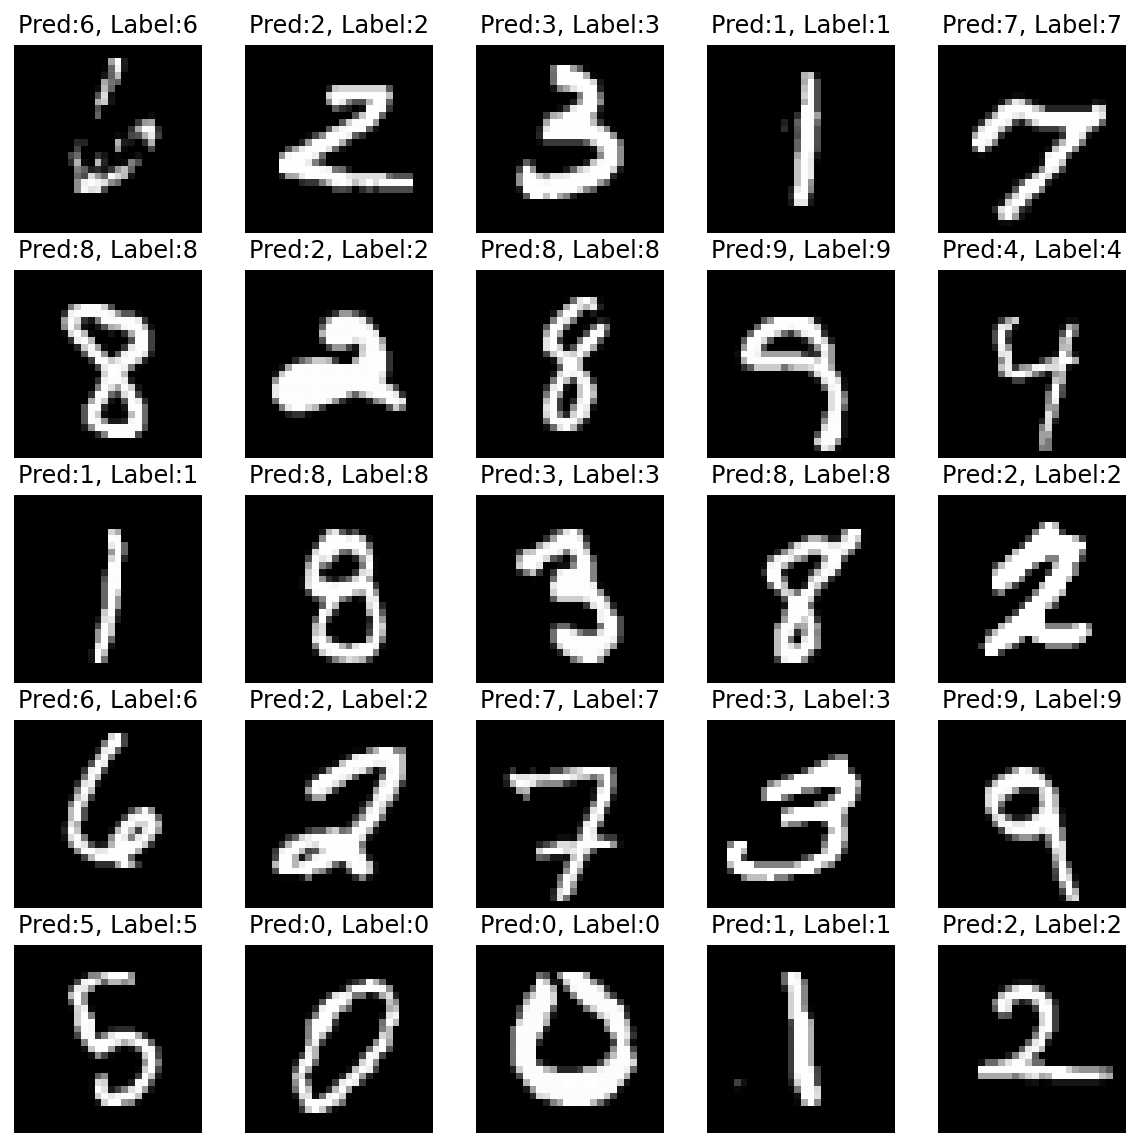

Done


In [11]:
n_sample=25
sample_indices=np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x=mnist_test.data[sample_indices]
test_y=mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval()
    y_pred=C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred=y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx],cmap='gray')
    plt.axis('off')
    plt.title(f'Pred:{y_pred[idx]}, Label:{test_y[idx]}')
plt.show()
print('Done')